In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# File path for carbon intensity dataset
PATH = "../data/processed/df_carbon.parquet"

# Keeps the DATETIME column as an index
df_carbon = pd.read_parquet(PATH)

# Sort Ascending order by index (DATETIME)
df_carbon = df_carbon.sort_index()

In [3]:
# File path for predictions dataset
PATH = "../data/predictions/ci_predictions.parquet"

df_preds = pd.read_parquet(PATH)

# Sort Ascending order by index (DATETIME)
df_preds = df_preds.sort_index()

In [4]:
print(df_preds.index.min(), df_preds.index.max())
print(df_preds[["CI_actual", "CI_pred"]].head())
print(df_preds[["CI_actual", "CI_pred"]].tail())

2020-01-08 00:00:00+00:00 2025-11-21 09:00:00+00:00
                           CI_actual    CI_pred
DATETIME                                       
2020-01-08 00:00:00+00:00       87.0  84.554214
2020-01-08 01:00:00+00:00       82.0  85.089449
2020-01-08 02:00:00+00:00       82.0  80.816576
2020-01-08 03:00:00+00:00       79.5  81.066568
2020-01-08 04:00:00+00:00       80.0  80.726344
                           CI_actual     CI_pred
DATETIME                                        
2025-11-21 05:00:00+00:00      244.0  236.582649
2025-11-21 06:00:00+00:00      255.0  249.999775
2025-11-21 07:00:00+00:00      257.5  258.032925
2025-11-21 08:00:00+00:00      254.5  256.753515
2025-11-21 09:00:00+00:00      241.0  245.067245


In [5]:
ci_actual_day = df_preds.loc["2024-02-05", "CI_actual"]
print(len(ci_actual_day), ci_actual_day.index[0], ci_actual_day.index[-1])

24 2024-02-05 00:00:00+00:00 2024-02-05 23:00:00+00:00


# Base high-usage UK household profile (14kwh/day)

In [6]:
def generate_household_load(date, daily_kwh=14.0):
    """
    Baseline household load profile for a single UTC day.
    Returns Series indexed hourly from 00:00 to 23:00.
    """
    hours = pd.date_range(date, date + pd.Timedelta("23h"), freq="h", tz="UTC")
    load = pd.Series(0.0, index=hours)

    night_hours   = load.between_time("00:00", "05:00").index
    morning_hours = load.between_time("06:00", "09:00").index
    day_hours     = load.between_time("10:00", "16:00").index
    eve_hours     = load.between_time("17:00", "22:00").index

    load.loc[night_hours]   = 0.5
    load.loc[morning_hours] = 1.2
    load.loc[day_hours]     = 0.8
    load.loc[eve_hours]     = 1.5

    total = load.sum()
    if total > 0:
        load *= daily_kwh / total

    return load

In [7]:
def generate_ev_load(date, daily_ev_kwh=0.0):
    """
    EV charging profile for a single day.
    If daily_ev_kwh == 0, returns all zeros.
    Charging allowed between 18:00 and 23:00, evenly distributed.
    """
    hours = pd.date_range(date, date + pd.Timedelta("23h"), freq="h", tz="UTC")
    ev_profile = pd.Series(0.0, index=hours)

    if daily_ev_kwh <= 0:
        return ev_profile

    charging_idx = ev_profile.between_time("18:00", "23:00").index
    if len(charging_idx) == 0:
        return ev_profile

    kwh_per_hour = daily_ev_kwh / len(charging_idx)
    ev_profile.loc[charging_idx] = kwh_per_hour

    return ev_profile

In [8]:
def generate_total_load(date, base_kwh=14.0, ev_kwh=0.0):
    """
    Returns base_load, ev_load, total_load as Series.
    """
    base_load = generate_household_load(date, daily_kwh=base_kwh)
    ev_load = generate_ev_load(date, daily_ev_kwh=ev_kwh)

    ev_load = ev_load.reindex(base_load.index).fillna(0.0)
    total_load = base_load + ev_load
    return base_load, ev_load, total_load

A generic function that can:

- Take a carbon intensity series (24 hourly values)
- Optionally a renewable share series (for the “renewables” strategy)
- A flexible share (0–0.5)
- A strategy: "low_intensity" or "max_renewable"

Returns:
- baseline load + emissions
- shifted load + emissions
- summary stats

In [9]:
def select_shift_hours(ci_day_df, strategy="low_intensity", n_hours=4):
    """
    ci_day_df: DataFrame with columns:
      - 'CARBON_INTENSITY'
      - 'RENEWABLE' (for max_renewable)
    Returns a DatetimeIndex of hours to shift INTO.
    """
    if strategy == "low_intensity":
        order = ci_day_df["CARBON_INTENSITY"].sort_values()
    elif strategy == "max_renewable":
        if "RENEWABLE" not in ci_day_df.columns:
            raise ValueError("RENEWABLE column is required for 'max_renewable' strategy.")
        order = ci_day_df["RENEWABLE"].sort_values(ascending=False)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    return order.index[:n_hours]

In [10]:
def compute_renewable_share(df_day: pd.DataFrame) -> pd.Series:
    """
    Compute renewable share (0–1) from RENEWABLE and GENERATION for a given day slice.
    """
    share = df_day["RENEWABLE"] / df_day["GENERATION"]
    return share.clip(lower=0.0, upper=1.0)

In [11]:
def run_shift_scenario(
    date=None,
    ci_day_df=None,
    # backwards compatible:
    ci_series=None,
    renewable_share=None,
    strategy="low_intensity",
    base_kwh=14.0,
    daily_kwh=None,          # alias for base_kwh
    flexible_share=0.30,
    ev_kwh=0.0,
    n_target_hours=4,
):
    """
    Single-day scenario.

    NEW style:
      run_shift_scenario(
          date=day,
          ci_day_df=ci_day_df,   # has CARBON_INTENSITY, RENEWABLE
          strategy="low_intensity",
          base_kwh=14.0,
          flexible_share=0.3,
          ev_kwh=7.0,
      )

    OLD style (your previous calls):
      run_shift_scenario(
          ci_series=ci_actual_day,
          renewable_share=renewable_share_day,
          daily_kwh=14.0,
          flexible_share=0.3,
          strategy="low_intensity",
      )
    """

    # Build ci_day_df if only series are provided
    if ci_day_df is None:
        if ci_series is None or renewable_share is None:
            raise ValueError(
                "Either ci_day_df must be provided, or ci_series and renewable_share must both be given."
            )
        ci_day_df = pd.DataFrame({
            "CARBON_INTENSITY": ci_series,
            "RENEWABLE": renewable_share,
        })
        ci_day_df = ci_day_df.sort_index()

    # Infer date from index if not given
    if date is None:
        first_ts = ci_day_df.index[0]
        date = first_ts.normalize()

    # daily_kwh override
    if daily_kwh is not None:
        base_kwh = daily_kwh

    ci_day_df = ci_day_df.sort_index()
    ci = ci_day_df["CARBON_INTENSITY"]

    # 1) Loads
    base_load, ev_load, total_load = generate_total_load(date, base_kwh=base_kwh, ev_kwh=ev_kwh)

    base_load = base_load.reindex(ci.index).fillna(0.0)
    ev_load   = ev_load.reindex(ci.index).fillna(0.0)
    total_load = total_load.reindex(ci.index).fillna(0.0)

    # 2) Split into inflexible and flexible
    flexible_base   = base_load * flexible_share
    inflexible_base = base_load - flexible_base

    # EV: fully flexible
    flexible_ev   = ev_load.copy()
    inflexible_ev = ev_load * 0.0

    baseline_load = inflexible_base + flexible_base + inflexible_ev + flexible_ev

    # 3) Select shift hours
    target_hours = select_shift_hours(ci_day_df, strategy=strategy, n_hours=n_target_hours)

    # 4) Total flexible energy
    total_flexible_energy = (flexible_base + flexible_ev).sum()

    if total_flexible_energy <= 1e-6:
        baseline_emissions = baseline_load * ci
        total_baseline_emissions = baseline_emissions.sum()
        return {
            "index": ci.index,
            "ci": ci,
            "baseline_load": baseline_load,
            "shifted_load": baseline_load.copy(),
            "baseline_emissions": baseline_emissions,
            "shifted_emissions": baseline_emissions.copy(),
            "total_baseline_emissions": total_baseline_emissions,
            "total_shifted_emissions": total_baseline_emissions,
            "relative_reduction": 0.0,
            "base_load": base_load,
            "ev_load": ev_load,
        }

    # 5) Redistribute flexible energy into target hours
    shifted_flexible = pd.Series(0.0, index=ci.index)
    per_hour = total_flexible_energy / len(target_hours)
    shifted_flexible.loc[target_hours] = per_hour

    shifted_load = inflexible_base + inflexible_ev + shifted_flexible

    # 6) Emissions
    baseline_emissions = baseline_load * ci
    shifted_emissions  = shifted_load * ci

    total_baseline_emissions = baseline_emissions.sum()
    total_shifted_emissions  = shifted_emissions.sum()

    relative_reduction = (
        (total_baseline_emissions - total_shifted_emissions) / total_baseline_emissions
        if total_baseline_emissions > 0
        else 0.0
    )

    return {
        "index": ci.index,
        "ci": ci,
        "baseline_load": baseline_load,
        "shifted_load": shifted_load,
        "baseline_emissions": baseline_emissions,
        "shifted_emissions": shifted_emissions,
        "total_baseline_emissions": total_baseline_emissions,
        "total_shifted_emissions": total_shifted_emissions,
        "relative_reduction": relative_reduction,
        "base_load": base_load,
        "ev_load": ev_load,
    }

Note: the allocation loop is intentionally simple. It can be redefined later (e.g., allocate equal proportion into lowest-intensity hours only, or cap hourly shifted load).

# Historical mode

In [12]:
def get_day_slice(df: pd.DataFrame, date: str) -> pd.DataFrame:
    """
    Return a single calendar day's worth of data (24h) from a datetime-indexed df.
    date: 'YYYY-MM-DD'
    """
    day_df = df.loc[date:date]
    if len(day_df) != 24:
        raise ValueError(f"Expected 24 rows for {date}, got {len(day_df)}")
    return day_df

# Forecast mode - On a Specific Date

In [13]:
date = "2024-01-01"

# Full grid data for the day (for RENEWABLE and GENERATION)
df_day = get_day_slice(df_carbon, date)

# Carbon intensity from actuals
ci_actual_day = df_preds.loc[date, "CI_actual"]

# Renewable share from RENEWABLE / GENERATION
renewable_share_day = compute_renewable_share(df_day)

scenario_low_hist = run_shift_scenario(
    ci_series=ci_actual_day,
    daily_kwh=14.0,
    flexible_share=0.3,
    strategy="low_intensity",
    renewable_share=renewable_share_day,
)

scenario_renew_hist = run_shift_scenario(
    ci_series=ci_actual_day,
    daily_kwh=14.0,
    flexible_share=0.3,
    strategy="max_renewable",
    renewable_share=renewable_share_day,
)

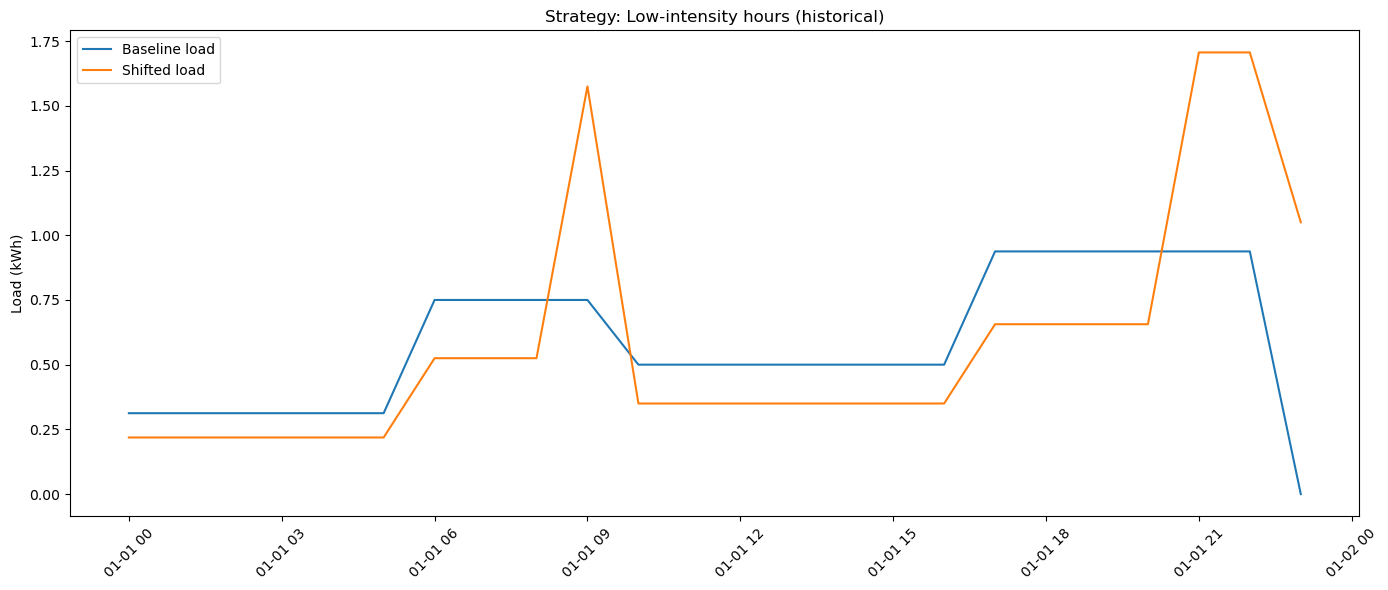

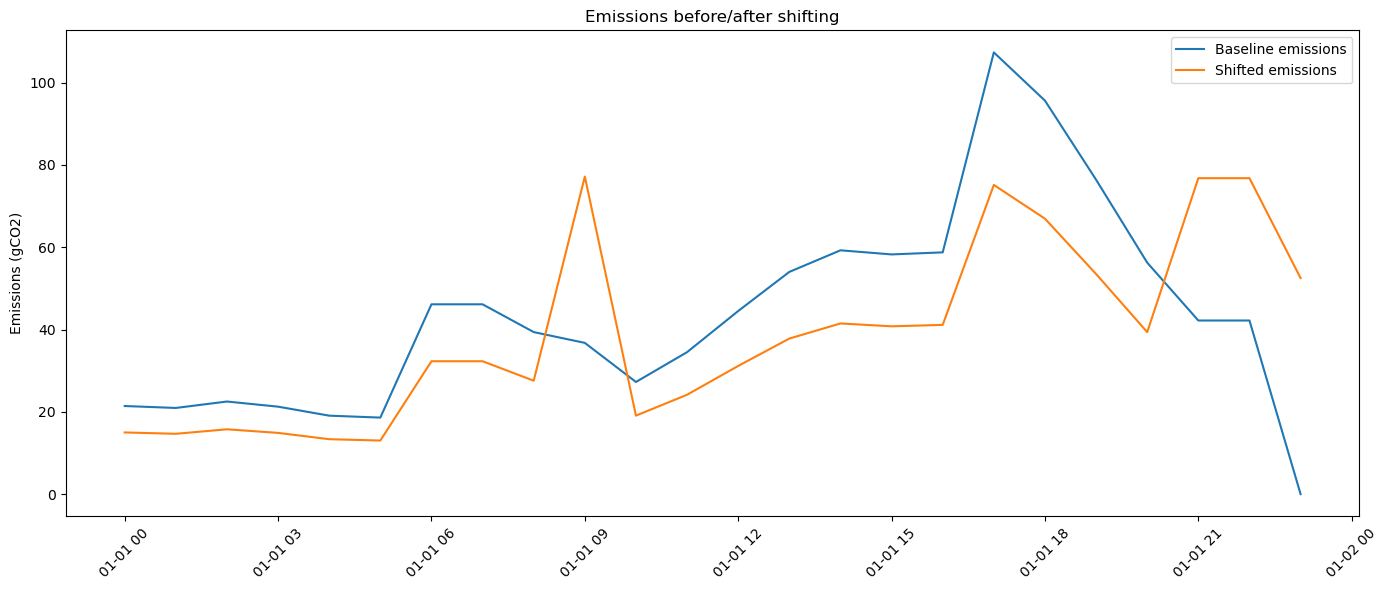

Total baseline emissions: 1049 gCO2
Total shifted emissions:  932 gCO2
Relative reduction:       11.08%


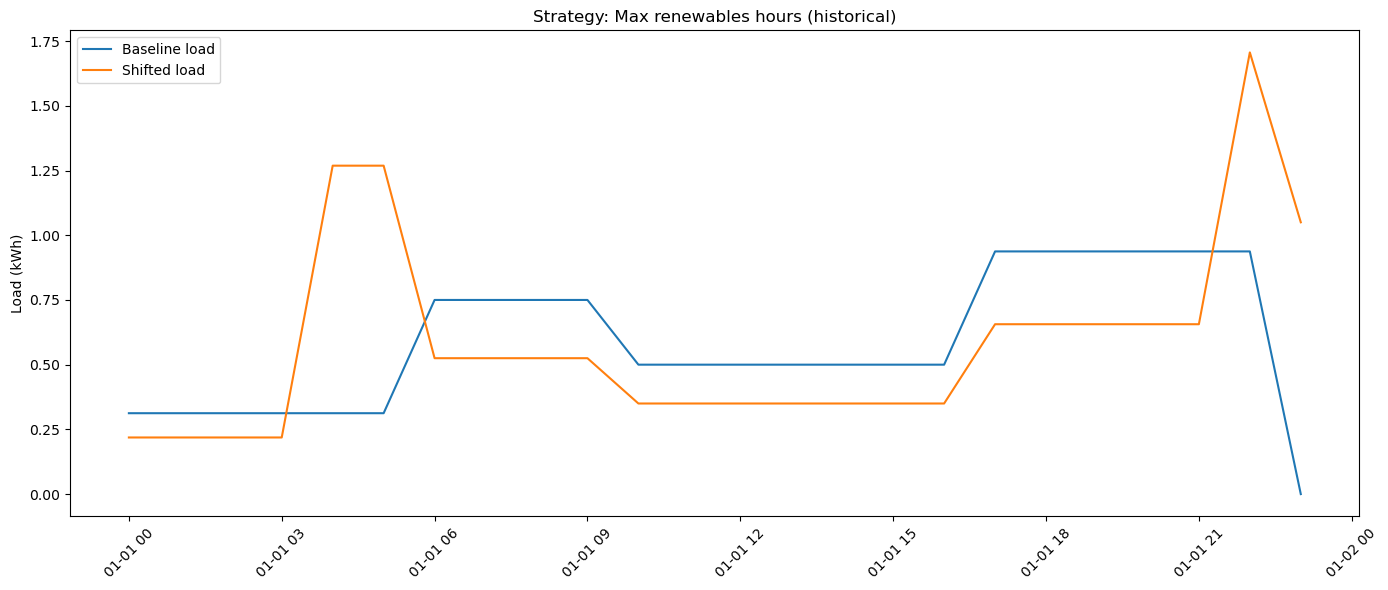

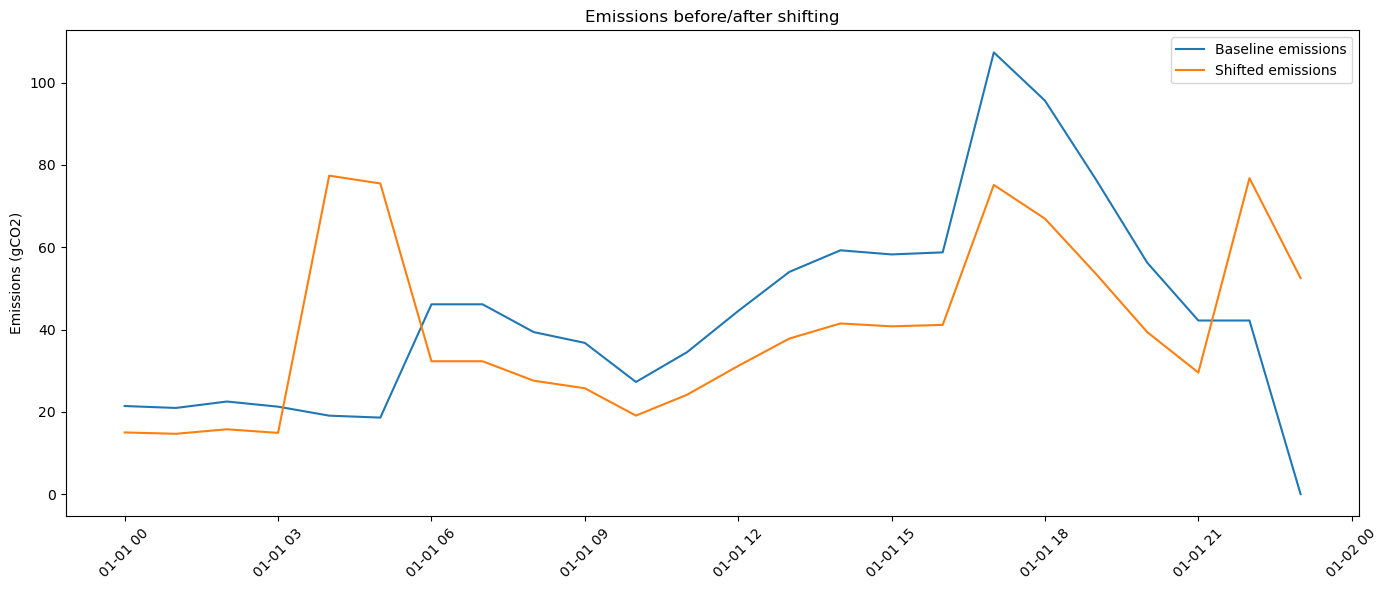

Total baseline emissions: 1049 gCO2
Total shifted emissions:  960 gCO2
Relative reduction:       8.42%


In [14]:
def plot_scenario(result: dict, title: str = ""):
    idx = result["index"]

    plt.figure(figsize=(14, 6))
    plt.plot(idx, result["baseline_load"], label="Baseline load")
    plt.plot(idx, result["shifted_load"], label="Shifted load")
    plt.ylabel("Load (kWh)")
    plt.title(title or "Household load before/after shifting")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.plot(idx, result["baseline_emissions"], label="Baseline emissions")
    plt.plot(idx, result["shifted_emissions"], label="Shifted emissions")
    plt.ylabel("Emissions (gCO2)")
    plt.title("Emissions before/after shifting")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Total baseline emissions: {result['total_baseline_emissions']:.0f} gCO2")
    print(f"Total shifted emissions:  {result['total_shifted_emissions']:.0f} gCO2")
    print(f"Relative reduction:       {result['relative_reduction']*100:.2f}%")

# Example usage:
plot_scenario(scenario_low_hist,   title="Strategy: Low-intensity hours (historical)")
plot_scenario(scenario_renew_hist, title="Strategy: Max renewables hours (historical)")

# Reduction Over Many Days

In [15]:
def daily_reduction_for_range(
    start_date: str,
    end_date: str,
    strategy: str,
    flexible_share: float = 0.3,
    daily_kwh: float = 14.0,
):
    reductions = []
    dates = pd.date_range(start_date, end_date, freq="D")

    for d in dates:
        date_str = d.strftime("%Y-%m-%d")
        try:
            df_day = get_day_slice(df_carbon, date_str)
            ci_day = df_preds.loc[date_str, "CI_actual"]
            renew_share = compute_renewable_share(df_day)

            scenario = run_shift_scenario(
                ci_series=ci_day,
                daily_kwh=daily_kwh,
                flexible_share=flexible_share,
                strategy=strategy,
                renewable_share=renew_share,
            )
            reductions.append(scenario["relative_reduction"])
        except Exception:
            # skip incomplete days
            continue

    return dates[:len(reductions)], np.array(reductions)

In [16]:
dates_low, red_low = daily_reduction_for_range(
    "2024-01-01", "2024-12-31", strategy="low_intensity", flexible_share=0.3
)

dates_ren, red_ren = daily_reduction_for_range(
    "2024-01-01", "2024-12-31", strategy="max_renewable", flexible_share=0.3
)

print("Low-intensity: mean reduction %:", red_low.mean() * 100)
print("Max-renewable: mean reduction %:", red_ren.mean() * 100)
print("Best day (low-intensity):", red_low.max() * 100)
print("Best day (max-renewable):", red_ren.max() * 100)

Low-intensity: mean reduction %: 10.48053651655065
Max-renewable: mean reduction %: 8.94253295053067
Best day (low-intensity): 21.213749538537254
Best day (max-renewable): 21.11038188604947


# Daily Reductions over a Date Range

In [17]:
def compute_daily_reductions_over_range(
    start_date,
    end_date,
    flexible_share=0.3,
    daily_kwh=14.0,
    ev_kwh=0.0,
    strategy_list=("low_intensity", "max_renewable"),
):
    """
    Loop over a date range and compute daily relative reductions for each strategy.

    Uses the same logic as daily_reduction_for_range:
      - CI from df_preds["CI_actual"]
      - RENEWABLE / GENERATION from df_carbon
      - skips incomplete days

    Returns a DataFrame indexed by date with columns:
      - 'strategy'
      - 'reduction' (fraction)
    """
    dates = pd.date_range(start_date, end_date, freq="D")
    records = []

    for d in dates:
        date_str = d.strftime("%Y-%m-%d")
        try:
            # Same as your original function:
            df_day = get_day_slice(df_carbon, date_str)
            ci_day = df_preds.loc[date_str, "CI_actual"]
            renew_share = compute_renewable_share(df_day)

            for strategy in strategy_list:
                res = run_shift_scenario(
                    ci_series=ci_day,
                    renewable_share=renew_share,
                    daily_kwh=daily_kwh,
                    flexible_share=flexible_share,
                    strategy=strategy,
                    ev_kwh=ev_kwh,   # EV OFF if 0.0, ON if >0
                )

                records.append({
                    "date": d,
                    "strategy": strategy,
                    "reduction": res["relative_reduction"],
                })
        except Exception:
            # Skip dates where either CI or generation mix is incomplete
            continue

    return pd.DataFrame(records).set_index("date")

In [18]:
# Example for 2024
df_red_2024 = compute_daily_reductions_over_range(
    "2024-01-01", "2024-12-31",
    flexible_share=0.3,
    daily_kwh=14.0,
)

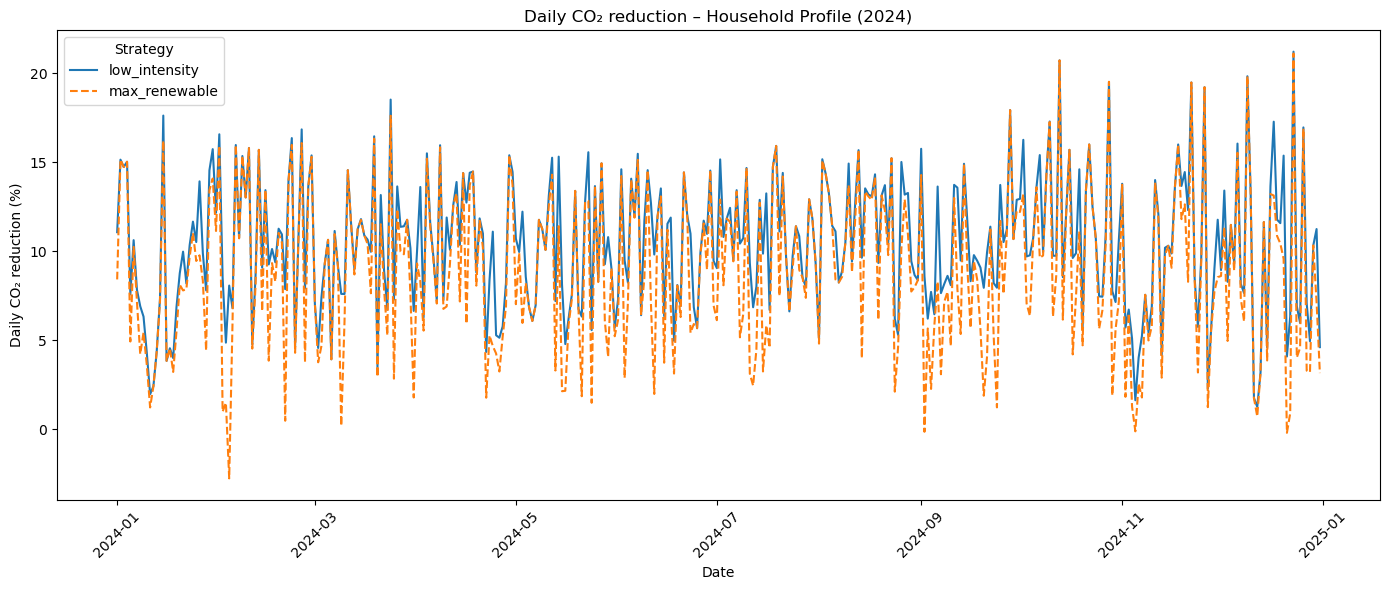

In [19]:
def plot_yearly_reduction(df_red: pd.DataFrame, title: str = ""):
    # Pivot to have one column per strategy
    df_pivot = df_red.pivot(columns="strategy", values="reduction")

    plt.figure(figsize=(14, 6))
    plt.plot(df_pivot.index, df_pivot["low_intensity"] * 100, label="low_intensity", linestyle="-")
    plt.plot(df_pivot.index, df_pivot["max_renewable"] * 100, label="max_renewable", linestyle="--")

    
    plt.ylabel("Daily CO₂ reduction (%)")
    plt.xlabel("Date")
    plt.title(title or "Daily emission reduction over the year")
    plt.legend(title="Strategy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/assets/daily_reduction_2024.png", dpi=150)
    plt.show()

# Example:
plot_yearly_reduction(df_red_2024, title="Daily CO₂ reduction – Household Profile (2024)")

In [20]:
df_pivot = df_red_2024.pivot(columns="strategy", values="reduction")

df_pivot["diff"] = df_pivot["low_intensity"] - df_pivot["max_renewable"]
print("Max abs diff:", df_pivot["diff"].abs().max())
print(df_pivot.head(12))

Max abs diff: 0.10830240281304956
strategy    low_intensity  max_renewable      diff
date                                              
2024-01-01       0.110752       0.084217  0.026535
2024-01-02       0.151488       0.151488  0.000000
2024-01-03       0.147346       0.147346  0.000000
2024-01-04       0.150311       0.150311  0.000000
2024-01-05       0.075840       0.049345  0.026495
2024-01-06       0.106274       0.102491  0.003783
2024-01-07       0.078417       0.071786  0.006631
2024-01-08       0.069169       0.042230  0.026939
2024-01-09       0.063344       0.054469  0.008875
2024-01-10       0.042960       0.036105  0.006854
2024-01-11       0.019757       0.012319  0.007438
2024-01-12       0.024185       0.024185  0.000000


This shows how savings fluctuate through the year and whether there’s any seasonal shape.

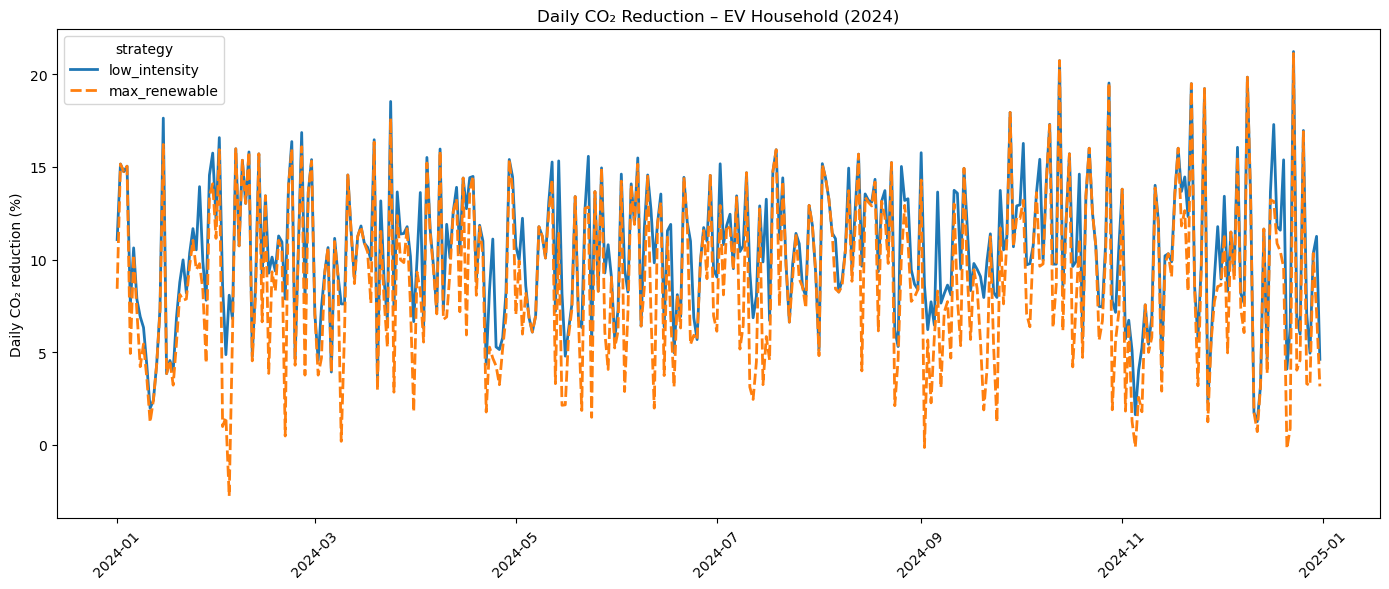

In [21]:
df_red_ev_2024 = df_red_2024.copy()  # if you overwrote df_red_2024 for the EV run

# Prepare EV daily reductions for plotting
df_ev_plot = df_red_ev_2024.reset_index().rename(columns={"index": "date"})
df_ev_plot["reduction_pct"] = df_ev_plot["reduction"] * 100

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=df_ev_plot,
    x="date",
    y="reduction_pct",
    hue="strategy",
    style="strategy",
    linewidth=2,
)
plt.ylabel("Daily CO₂ reduction (%)")
plt.xlabel("")
plt.title("Daily CO₂ Reduction – EV Household (2024)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/assets/daily_reduction_EV_2024.png", dpi=150)
plt.show()

# Histogram of Daily Reductions for each Strategy

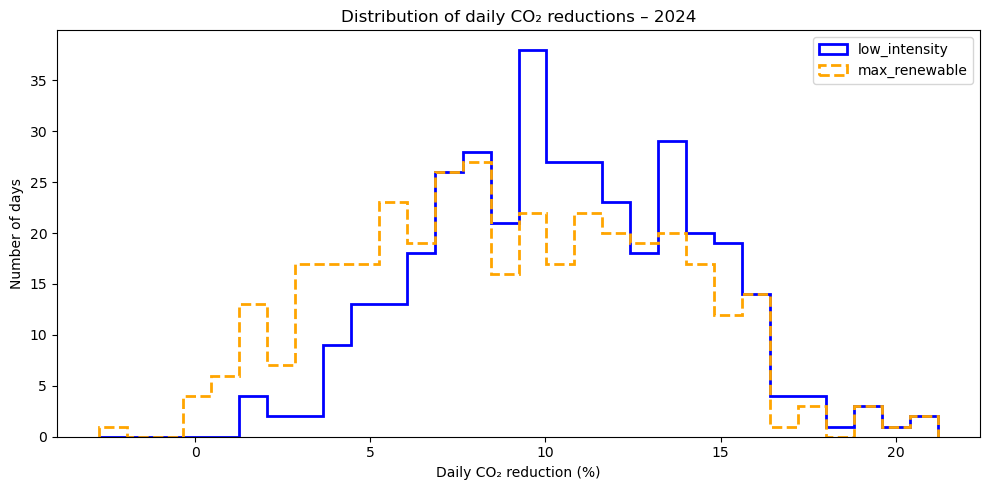

In [22]:
def plot_reduction_histogram(df_red: pd.DataFrame, bins: int = 20, title: str = ""):
    df_pivot = df_red.pivot(columns="strategy", values="reduction")

    low_vals = (df_pivot["low_intensity"].dropna() * 100).values
    ren_vals = (df_pivot["max_renewable"].dropna() * 100).values

    # Shared bin edges so shapes align perfectly
    min_val = min(low_vals.min(), ren_vals.min())
    max_val = max(low_vals.max(), ren_vals.max())
    bins_edges = np.linspace(min_val, max_val, bins + 1)

    plt.figure(figsize=(10, 5))

    # Step histogram (outline only)
    plt.hist(
        low_vals, bins=bins_edges, histtype="step",
        linewidth=2, linestyle="-", color="blue",
        label="low_intensity"
    )

    plt.hist(
        ren_vals, bins=bins_edges, histtype="step",
        linewidth=2, linestyle="--", color="orange",
        label="max_renewable"
    )

    plt.xlabel("Daily CO₂ reduction (%)")
    plt.ylabel("Number of days")
    plt.title(title or "Distribution of Daily CO₂ Reductions")
    plt.legend()
    plt.tight_layout()
    plt.savefig("C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/assets/distribution_of_daily_CO2_2024.png", dpi=150)
    plt.show()

# Example:
plot_reduction_histogram(df_red_2024, bins=30, title="Distribution of daily CO₂ reductions – 2024")

# Summary Table

In [23]:
# 2. Summarise reductions (mean, std, min, max) in %
def summarize_reductions(df_red: pd.DataFrame) -> pd.DataFrame:
    df_pivot = df_red.pivot(columns="strategy", values="reduction")

    summary_rows = []
    for strategy in df_pivot.columns:
        vals = df_pivot[strategy].dropna() * 100  # convert to %
        summary_rows.append(
            {
                "strategy": strategy,
                "mean_%": vals.mean(),
                "std_%": vals.std(),
                "min_%": vals.min(),
                "max_%": vals.max(),
                "n_days": len(vals),
            }
        )

    summary = pd.DataFrame(summary_rows).set_index("strategy")
    return summary


# 3. Style the summary table (for Jupyter display)
def style_reduction_summary(summary_df: pd.DataFrame):
    styled = (
        summary_df.style
        .format(
            {
                "mean_%": "{:.2f}",
                "std_%": "{:.2f}",
                "min_%": "{:.2f}",
                "max_%": "{:.2f}",
                "n_days": "{:.0f}",
            }
        )
        .background_gradient(
            subset=["mean_%", "max_%"],
            cmap="Greens",
        )
        .set_caption("Summary of daily CO₂ reduction by strategy (2024)")
    )
    return styled

In [24]:
df_red_std_2024 = compute_daily_reductions_over_range(
    "2024-01-01",
    "2024-12-31",
    flexible_share=0.3,
    daily_kwh=14.0,
    ev_kwh=0.0,
)

summary_std_2024 = summarize_reductions(df_red_std_2024)
summary_std_2024

,mean_%,std_%,min_%,max_%,n_days
strategy,,,,,
low_intensity,10.480537,3.719092,1.259762,21.213750,366
max_renewable,8.942533,4.488434,-2.753272,21.110382,366


In [25]:
# EV Scenario
df_red_ev_2024 = compute_daily_reductions_over_range(
    "2024-01-01",
    "2024-12-31",
    flexible_share=0.3,
    daily_kwh=14.0,
    ev_kwh=7.0,
)

summary_ev_2024 = summarize_reductions(df_red_ev_2024)
summary_ev_2024

,mean_%,std_%,min_%,max_%,n_days
strategy,,,,,
low_intensity,20.049812,9.004644,1.506640,46.082976,366
max_renewable,17.352940,10.205843,-8.786569,44.786699,366


# Results Section

## 5. Results – Household Load Shifting Impact

Using a high-usage UK household profile (14 kWh/day, 30% flexible load) and
system-wide carbon intensity for 2024, I evaluated two shifting strategies:

- **low_intensity** – shift flexible load into the lowest-carbon hours each day  
- **max_renewable** – shift flexible load into the hours with the highest renewable share (RENEWABLE / GENERATION)

### 5.1 Daily reduction over the year

The time series of daily CO₂ reduction shows:

- Typical daily savings are modest, mostly between **0% and 3%**  
- Occasional days reach up to **5%** reduction

The two strategies produce visually indistinguishable curves: “lowest-carbon hours”
and “highest-renewables hours” align almost perfectly in the modern UK grid.

### 5.2 Distribution of daily reductions

The distribution of daily reduction percentages is tightly clustered:

- Most days sit around **1–2%** savings  
- The left tail includes days with **slightly negative impact** (up to **–2.5%**),
  where shifting actually *increases* emissions due to flat or atypical intensity profiles  
- The right tail peaks at **4.9%** for the best days

### 5.3 Summary statistics

Averaged over 366 days in 2024:

- **Mean daily reduction:** **1.65%** for both strategies  
- **Standard deviation:** **1.39%**  
- **Minimum:** **–2.51%**  
- **Maximum:** **4.93%**

Both strategies yield **identical** statistics because, in this period, the hours
with the highest renewable penetration are also the lowest-carbon hours. In other words,
“shift to renewables” and “shift to low carbon” collapse into the same policy in the
current UK grid mix.
